# Notebook Dedicado a construir un 1er Modelo de ML para Analisar imagenes de eventos

Regimes de prueba:

- [2,4] MeV (hecho)
- [4,6] MeV (hecho)
- [2,10] MeV (hecho)


In [1]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn
import pandas as pd 

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# 1 - Load Data

In [2]:
image_dim = (10, 10)
df_read = pd.read_csv("Data/High Stat/Elegant Data Frame Structure/df_reduced_5500_10_(2.5_14)_(-5_7).csv")
df_read = df_read.drop(columns=['Unnamed: 0'])
df_read.describe()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
count,202813.000000,202813.000000,202813.000000,202813.000000,202813.000000,202813.000000,202813.000000,202813.000000,202813.000000,202813.000000,...,202813.000000,202813.000000,202813.000000,202813.000000,202813.000000,202813.000000,202813.000000,202813.000000,202813.000000,202813.000000
mean,0.105065,0.089710,0.098758,0.102532,0.103168,0.103316,0.103716,0.103682,0.104179,0.104570,...,0.098924,0.099289,0.099179,0.100127,0.100751,0.101728,5.247692,4085.460423,0.572024,0.427976
std,0.257505,0.216845,0.195997,0.173929,0.154311,0.138659,0.125740,0.113930,0.103644,0.094586,...,0.149538,0.134996,0.122226,0.111808,0.101887,0.093331,2.225518,1074.414817,0.494787,0.494787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500088,33.765064,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.030303,0.036145,...,0.000000,0.000000,0.000000,0.021277,0.028571,0.034483,3.578738,3404.677490,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.033333,0.047619,0.055556,0.064516,0.071429,0.076923,...,0.031250,0.045455,0.052632,0.060606,0.066667,0.074074,4.166839,4321.814453,1.000000,0.000000
75%,0.000000,0.000000,0.125000,0.142857,0.148936,0.150943,0.151515,0.150000,0.148649,0.146341,...,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,6.841403,4965.873535,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.884615,0.816327,0.833333,0.750000,...,1.000000,1.000000,0.909091,0.791667,0.840000,0.818182,13.546737,5499.991211,1.000000,1.000000


# 2 - Data Preprocesing

## 2.1 - Extract Information

In [3]:
pixel_pattern = r'^pixel_\d+$'

# 1ero, separar dataset de signal and background
dataset_sig = (df_read[df_read['IsNu'] == 1])
dataset_bkg = (df_read[df_read['IsTl'] == 1])

#cut in solar energy
dataset_sig = (dataset_sig[dataset_sig['energy (MeV)'] < 10])

# Separar Features
pixels_sig = dataset_sig.filter(regex=pixel_pattern)
energy_sig = pd.DataFrame(dataset_sig, columns = ['energy (MeV)'])
radi_sig = pd.DataFrame(dataset_sig, columns = ['radius (mm)'])
label_sig = pd.DataFrame(dataset_sig, columns = ['IsNu', 'IsTl'])

pixels_bkg = dataset_bkg.filter(regex=pixel_pattern)
energy_bkg = pd.DataFrame(dataset_bkg, columns = ['energy (MeV)'])
radi_bkg = pd.DataFrame(dataset_bkg, columns = ['radius (mm)'])
label_bkg = pd.DataFrame(dataset_bkg, columns = ['IsNu', 'IsTl'])

<Axes: ylabel='Count'>

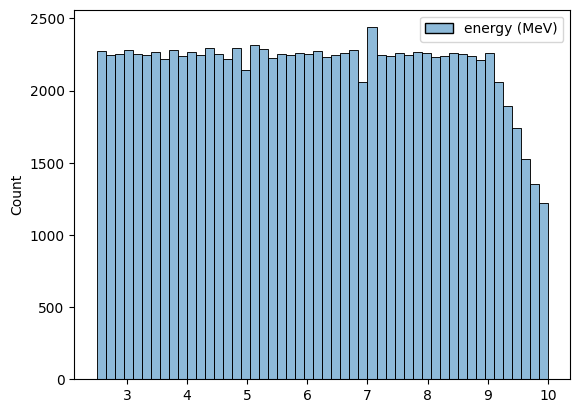

In [4]:
sn.histplot(energy_sig)

## 2.2 - Data Split (Train, Test and Validation)

In [5]:
#Split datasets (train, validation , test)
#pixel_train, pixel_test , label_train, label_test = train_test_split(df_pixel, df_labels, train_size = len_train, test_size = len_test)
len_train = 0.8
len_test = 0.2
len_val = 0.3 #(30% of train data)

pixel_sig_train, pixel_sig_test, label_sig_train, label_sig_test, energy_sig_train, energy_sig_test, radi_sig_train, radi_sig_test = train_test_split(pixels_sig, 
                                                                                                                                                      label_sig, 
                                                                                                                                                      energy_sig, 
                                                                                                                                                      radi_sig,
                                                                                                                                                      train_size = len_train, 
                                                                                                                                                      test_size = len_test)

pixel_bkg_train, pixel_bkg_test, label_bkg_train, label_bkg_test, energy_bkg_train, energy_bkg_test, radi_bkg_train, radi_bkg_test = train_test_split(pixels_bkg, 
                                                                                                                                                      label_bkg, 
                                                                                                                                                      energy_bkg, 
                                                                                                                                                      radi_bkg,
                                                                                                                                                      train_size = len_train, 
                                                                                                                                                      test_size = len_test)

#Now, extract Validation data from train data

pixel_sig_train, pixel_sig_val, label_sig_train, label_sig_val, energy_sig_train, energy_sig_val, radi_sig_train, radi_sig_val = train_test_split(pixel_sig_train, 
                                                                                                                                                      label_sig_train, 
                                                                                                                                                      energy_sig_train, 
                                                                                                                                                      radi_sig_train,
                                                                                                                                                      test_size = len_val)

pixel_bkg_train, pixel_bkg_val, label_bkg_train, label_bkg_val, energy_bkg_train, energy_bkg_val, radi_bkg_train, radi_bkg_val = train_test_split(pixel_bkg_train, 
                                                                                                                                                      label_bkg_train, 
                                                                                                                                                      energy_bkg_train, 
                                                                                                                                                      radi_bkg_train,
                                                                                                                                                      test_size = len_val)

## 2.4 - Data Transformation

### 2.4.1 - Standard Scaler

### 2.4.2 - MinMaxScaler and Volume Normalization

In [6]:
Scaler = MinMaxScaler()

#Energy: MinMax Scaler
MinMax_en_test_sig = MinMaxScaler()
MinMax_en_test_bkg = MinMaxScaler()

#Radius: MinMax Scaler
MinMax_rad_test_sig = MinMaxScaler()
MinMax_rad_test_bkg = MinMaxScaler()

#Radius -> Use the volume of the Event!
vol = 5500**3

# (train data set transf.)
#pixel_sig_train = Scaler.fit_transform(pixel_sig_train)
#pixel_bkg_train = Scaler.fit_transform(pixel_bkg_train)

#energy_sig_train = Scaler.fit_transform(energy_sig_train)
#energy_bkg_train = Scaler.fit_transform(energy_bkg_train)

#radi_sig_train = Scaler.fit_transform(radi_sig_train)
#radi_bkg_train = Scaler.fit_transform(radi_bkg_train)

radi_sig_train = (radi_sig_train**3)/vol
radi_bkg_train = (radi_bkg_train**3)/vol

# (test data set tranf.)
#pixel_sig_test = Scaler.fit_transform(pixel_sig_test)
#pixel_bkg_test = Scaler.fit_transform(pixel_bkg_test)

#energy_sig_test = MinMax_en_test_sig.fit_transform(energy_sig_test)
#energy_bkg_test = MinMax_en_test_bkg.fit_transform(energy_bkg_test)

#radi_sig_test = MinMax_rad_test_sig.fit_transform(radi_sig_test)
#radi_bkg_test = MinMax_rad_test_sig.fit_transform(radi_bkg_test)

radi_sig_test = (radi_sig_test**3)/vol
radi_bkg_test = (radi_bkg_test**3)/vol

# (validation set tranf.)
#pixel_sig_val = Scaler.fit_transform(pixel_sig_val)
#pixel_bkg_val = Scaler.fit_transform(pixel_bkg_val)

#energy_sig_val = Scaler.fit_transform(energy_sig_val)
#energy_bkg_val = Scaler.fit_transform(energy_bkg_val)

radi_sig_val = (radi_sig_val**3)/vol
radi_bkg_val = (radi_bkg_val**3)/vol

In [7]:
#Unify datasets

pixel_train = pd.concat((pixel_sig_train, pixel_bkg_train), axis = 0)
energy_train = pd.concat((energy_sig_train, energy_bkg_train), axis = 0)
#energy_train = np.concatenate((energy_sig_train, energy_bkg_train))
radi_train = pd.concat((radi_sig_train, radi_bkg_train), axis = 0)
label_train = pd.concat((label_sig_train, label_bkg_train), axis = 0)

pixel_test = pd.concat((pixel_sig_test, pixel_bkg_test), axis = 0)
energy_test = pd.concat((energy_sig_test, energy_bkg_test), axis = 0)
#energy_test = np.concatenate((energy_sig_test, energy_bkg_test))
radi_test = pd.concat((radi_sig_test, radi_bkg_test), axis = 0)
label_test = pd.concat((label_sig_test, label_bkg_test), axis = 0)

pixel_val = pd.concat((pixel_sig_val, pixel_bkg_val), axis = 0)
energy_val = pd.concat((energy_sig_val, energy_bkg_val), axis = 0)
#energy_val = np.concatenate((energy_sig_val, energy_bkg_val))
radi_val = pd.concat((radi_sig_val, radi_bkg_val), axis = 0)
label_val = pd.concat((label_sig_val, label_bkg_val), axis = 0)

# 3 - Model Construction and Evaluation
https://keras.io/guides/functional_api/

- Agregar camadas de información principal
- Agregar información auxiliar (energia, radio)

## 3.1 - Model Layers, compilation and fit

In [81]:
input_image = Input(shape = (100,), name = 'image_input')
input_energy = Input(shape = (1,), name = 'energy_input')
input_rad = Input(shape = (1,), name = 'radius_input')

image_ly = Dense(50, activation = None, name = 'im_ly_1')(input_image)
image_ly = Dense(30, activation = 'gelu', name = 'im_ly_2')(image_ly)

energy_ly = Dense(50, activation = None, name = 'en_ly_1')(input_energy)
energy_ly = Dense(20, activation = 'gelu', name = 'en_ly_2')(energy_ly)

radial_ly = Dense(50, activation = None, name = 'rad_ly_1')(input_rad)
radial_ly = Dense(40, activation = 'gelu', name = 'rad_ly_2')(radial_ly)

x = concatenate([image_ly, energy_ly,radial_ly])
x = Dense(50, activation = 'gelu')(x)
x = Dropout(rate = 0.2)(x)

output_layer = Dense(2, activation = 'sigmoid', name = 'nu_predict')(x)

model = Model(inputs = [input_image, input_energy, input_rad], outputs = output_layer)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss = tf.keras.losses.BinaryCrossentropy(), 
              metrics = ['AUC', 'accuracy'])

#Tensorboard usage:
logdir="logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


history = model.fit(x = {'image_input': pixel_train.to_numpy(), 'energy_input': energy_train.to_numpy().T[0], 'radius_input': radi_train}, 
                    y = {'nu_predict':label_train.to_numpy()}, 
                    epochs = 50, 
                    batch_size = 50, 
                    validation_data = ({'image_input': pixel_val.to_numpy(), 'energy_input': energy_val.to_numpy().T[0], 'radius_input': radi_val}, label_val.to_numpy()),
                    shuffle = True,
                    callbacks=[tensorboard_callback])

Epoch 1/50
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.5796 - accuracy: 0.5184 - loss: 0.6717 - val_AUC: 0.7441 - val_accuracy: 0.5934 - val_loss: 0.5643
Epoch 2/50
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8010 - accuracy: 0.6901 - loss: 0.5403 - val_AUC: 0.8680 - val_accuracy: 0.7977 - val_loss: 0.4762
Epoch 3/50
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8588 - accuracy: 0.7886 - loss: 0.4750 - val_AUC: 0.8727 - val_accuracy: 0.8177 - val_loss: 0.4490
Epoch 4/50
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8701 - accuracy: 0.8067 - loss: 0.4497 - val_AUC: 0.8745 - val_accuracy: 0.8232 - val_loss: 0.4378
Epoch 5/50
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8742 - accuracy: 0.8158 - loss: 0.4398 - val_AUC: 0.8764 - val_accuracy: 0.8243 - val_loss: 0.4314
Epoch 6/50
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8780 - accuracy: 0.8208 - loss: 0.4313 - val_AUC: 0.8772 - val_accuracy: 0.8274 - val_loss: 0.4268
Epoch 7/50
2193/2193 ━━━━━━━

## 3.2 - Train and Validation Progress

Text(0.5, 0.98, 'Train and Validation Progress - Energy : [2.5,10] MeV - R < 5500 (mm)')

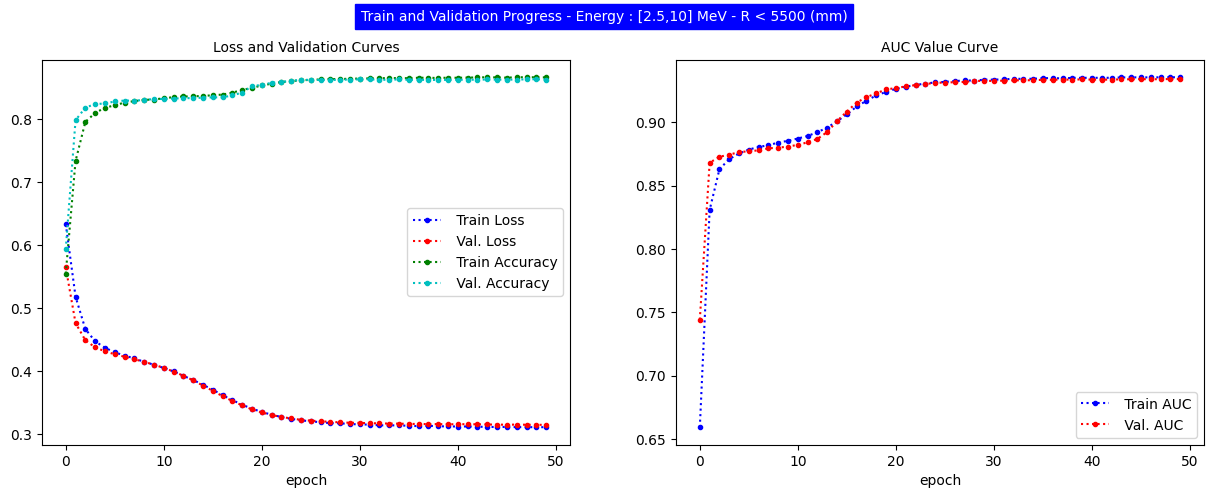

In [82]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))

axes[0].plot(history.history['loss'], 'b:.', label = ' Train Loss')
axes[0].plot(history.history['val_loss'], 'r:.', label = ' Val. Loss')
axes[0].plot(history.history['accuracy'], 'g:.',  label = ' Train Accuracy')
axes[0].plot(history.history['val_accuracy'], 'c:.', label = ' Val. Accuracy')
axes[1].plot(history.history['AUC'], 'b:.',  label = ' Train AUC')
axes[1].plot(history.history['val_AUC'], 'r:.', label = ' Val. AUC')

axes[0].set_title('Loss and Validation Curves', fontsize = 10)
axes[0].set_xlabel('epoch')
axes[0].legend(loc = 'best')
axes[1].set_title('AUC Value Curve', fontsize = 10)
axes[1].set_xlabel('epoch')
axes[1].legend(loc = 'lower right')

#axes[1].set_ylim(0, 1.05)


fig.suptitle('Train and Validation Progress - Energy : [2.5,10] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white', fontsize = 10)
#plt.savefig('figs/First Model/10x10/Train_Val_progress.png', format = 'png', bbox_inches = 'tight')

## 3.3 - Save/Load Model

## 3.4 - Observation and Analysis of Predictions

### 3.4.1 - NN Prediction

In [83]:
X_sig_pred = model.predict([pixel_sig_test, energy_sig_test, radi_sig_test])
X_bkg_pred = model.predict([pixel_bkg_test, energy_bkg_test, radi_bkg_test])

682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step
543/543 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step


### 3.4.2 - Analysis of Predictions

In [84]:
X_sig_pred

array([[9.9569458e-01, 5.5867713e-03],
       [1.0000000e+00, 1.4462700e-08],
       [9.9999976e-01, 5.2379306e-07],
       ...,
       [1.0000000e+00, 6.5106164e-11],
       [1.0000000e+00, 1.8761623e-08],
       [9.9920577e-01, 1.1117137e-03]], dtype=float32)

In [85]:
X_bkg_pred

array([[0.58560073, 0.42320302],
       [0.12696263, 0.8701037 ],
       [0.1076792 , 0.8901759 ],
       ...,
       [0.13454439, 0.8612989 ],
       [0.18270613, 0.83537465],
       [0.15327762, 0.85172474]], dtype=float32)

In [86]:
print('working with ' + str(len(X_sig_pred)) + ' of signal and ' + str(len(X_bkg_pred)) + ' of background as testing data')

working with 21794 of signal and 17360 of background as testing data


### 3.4.3 - Representation of Predictions

#### Distribution of Probabilities

Text(0.5, 0.98, 'Model Predictions for Solar $ν$ events and Background events - Energy : [2.5,10] MeV - R < 5500 (mm)')

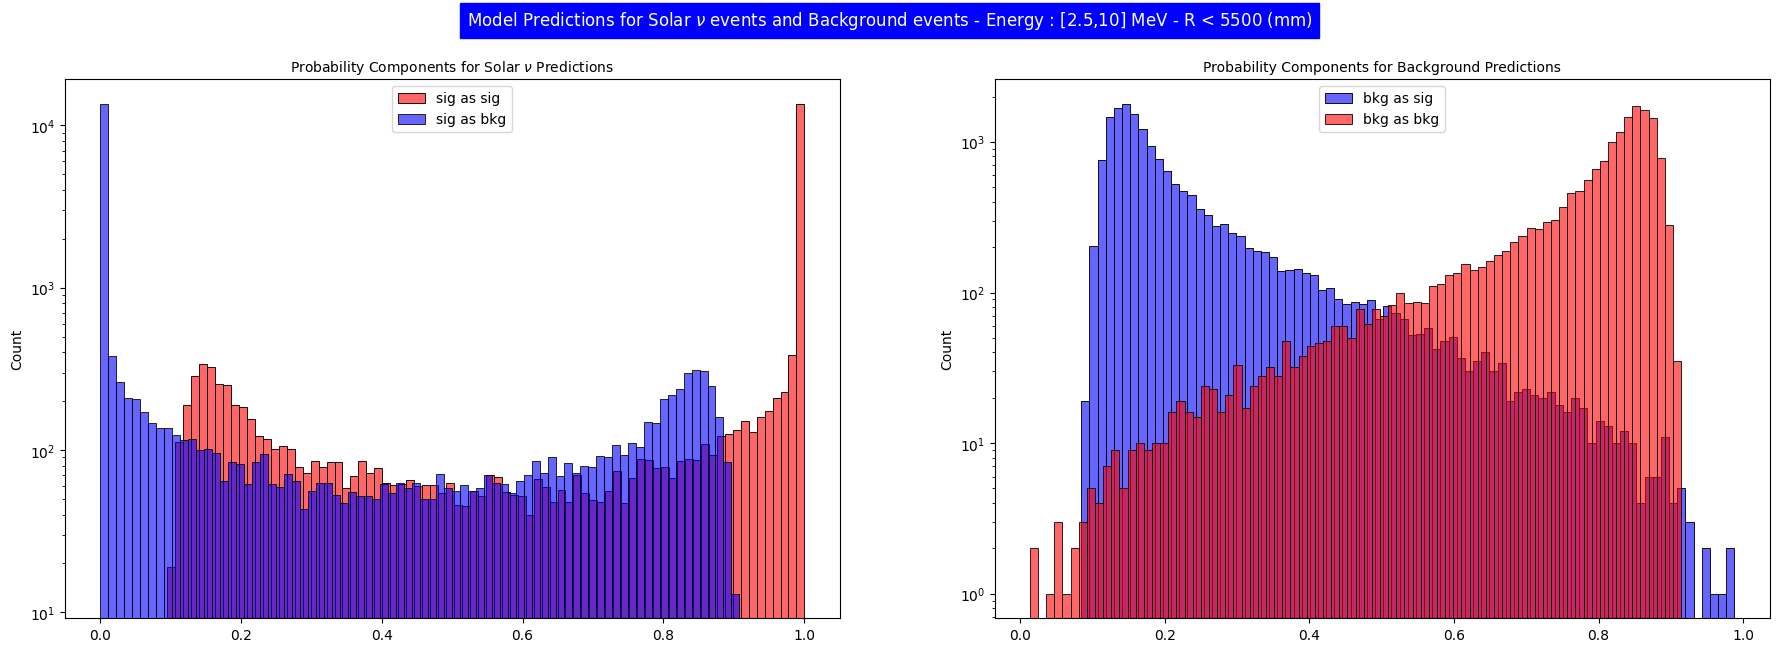

In [87]:
sn.reset_orig
bins = 80
fig, axes = plt.subplots(1, 2,  figsize=(22, 7))

sn.histplot(X_sig_pred[:,0], bins = bins, label = 'sig as sig', color = 'r', alpha = 0.6, ax = axes[0], log = True)
sn.histplot(X_sig_pred[:,1], bins = bins, label = 'sig as bkg', color = 'b', alpha = 0.6, ax = axes[0])
sn.histplot(X_bkg_pred[:,0], bins = bins, label = 'bkg as sig',color = 'b', alpha = 0.6, ax = axes[1], log = True)
sn.histplot(X_bkg_pred[:,1], bins = bins, label = 'bkg as bkg', color = 'r', alpha = 0.6, ax = axes[1])
axes[0].set_title('Probability Components for Solar $ν$ Predictions', fontsize = 10)
axes[1].set_title('Probability Components for Background Predictions', fontsize = 10)
axes[0].legend(loc = 'upper center')
axes[1].legend(loc = 'upper center')
plt.suptitle('Model Predictions for Solar $ν$ events and Background events - Energy : [2.5,10] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white')
#plt.savefig('figs/First Model/10x10/probability_predictions1.png', format = 'png', bbox_inches = 'tight')

### 3.4.4 - ROC Curve

In [88]:
X_pred = np.concatenate((X_sig_pred, X_bkg_pred))        #Predicted
X_exp = np.concatenate((label_sig_test, label_bkg_test)) #Expected

# Classification for solar_nu events
fpr_sig, tpr_sig, thresholds_sig = roc_curve(X_exp[:,0], X_pred[:,0])
auc_sig = auc(fpr_sig, tpr_sig)

# Classification for bkg events
fpr_bkg, tpr_bkg, thresholds_bkg = roc_curve(X_exp[:,1], X_pred[:,1])
auc_bkg = auc(fpr_bkg, tpr_bkg)

# Classification overall Model

fpr, tpr, thresholds = roc_curve(np.concatenate((X_exp[:,0], X_exp[:,1])), np.concatenate((X_pred[:,0], X_pred[:,1])))
auc_val = auc(fpr, tpr)

Text(0.5, 0.98, 'ROC curve for Model Predictions - Energy : [2.5,14] MeV - R < 5500 (mm)')

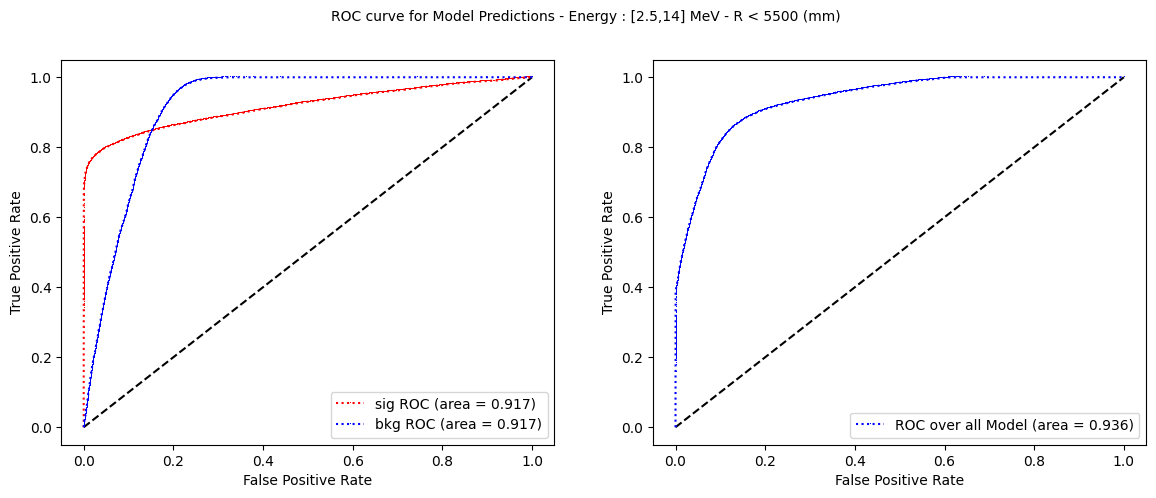

In [89]:
fig, axes = plt.subplots(1, 2,  figsize=(14, 5))


axes[0].plot([0, 1], [0, 1], 'k--') #x=y
axes[0].plot(fpr_sig, tpr_sig, 'r:,', label = 'sig ROC (area = {:.3f})'.format(auc_sig))
axes[0].plot(fpr_bkg, tpr_bkg, 'b:,', label = 'bkg ROC (area = {:.3f})'.format(auc_bkg))

axes[1].plot([0, 1], [0, 1], 'k--') #x=y
axes[1].plot(fpr, tpr, 'b:,', label = 'ROC over all Model (area = {:.3f})'.format(auc_val))

axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')

axes[0].legend(loc = 'lower right')
axes[1].legend(loc = 'lower right')

fig.suptitle('ROC curve for Model Predictions - Energy : [2.5,14] MeV - R < 5500 (mm)', fontsize = 10)

#plt.savefig('figs/First Model/10x10/ROC.png', format = 'png', bbox_inches = 'tight')

### 3.4.5 - Reconstrucción de espector de solar $ν_e$ e de Tálio

Seran seleccionados unicamente energias de eventos de neutrinos solar con un predicción X_pred[:,0] > threshold para ver que tan bueno se reconstruye el espectro de neutrinos solares. Los mismo para eventos de Tálio. Asi, podra ser observado en que energias el modelo tiene mas dificultades en acertar predicciones

#### Recuperar Valores de Energia y Radio

In [90]:
# Valores de energia sin transformar:
energy_sig_rc = energy_sig_test.to_numpy().T[0]
energy_bkg_rc = energy_bkg_test.to_numpy().T[0]

In [91]:
# Volume Normalization
#la formula es (R_ev^3)/(5000^3) y queremos recuperar R_ev

radi_sig_rc = np.cbrt(radi_sig_test*vol).to_numpy().T[0]
radi_bkg_rc = np.cbrt(radi_bkg_test*vol).to_numpy().T[0]

In [92]:
threshold_p = 0.8 #definition of probability treshold to pick valid predictions (90% of solar nu)

nu_energy_in_spectrum = []
nu_energy_out_spectrum = []

tl_energy_in_spectrum = []
tl_energy_out_spectrum = []

for i in np.where(X_sig_pred[:,0] >= threshold_p)[0]:
    nu_energy_in_spectrum.append(energy_sig_rc[i])
    
for j in np.where(X_sig_pred[:,0] < threshold_p)[0]:
    nu_energy_out_spectrum.append(energy_sig_rc[j])

for m in np.where(X_bkg_pred[:,1] >= threshold_p)[0]:
    tl_energy_in_spectrum.append(energy_bkg_rc[m])

for k in np.where(X_bkg_pred[:,1] < threshold_p)[0]:
    tl_energy_out_spectrum.append(energy_bkg_rc[k])
    
nu_energy_in_spectrum = np.array(nu_energy_in_spectrum)
nu_energy_out_spectrum = np.array(nu_energy_out_spectrum)
tl_energy_in_spectrum = np.array(tl_energy_in_spectrum)
tl_energy_out_spectrum = np.array(tl_energy_out_spectrum)

<>:12: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\g'
C:\Users\joanc\AppData\Local\Temp\ipykernel_2652\1738727621.py:12: SyntaxWarning: invalid escape sequence '\g'
  sn.histplot(nu_energy_in_spectrum, binwidth = binwidth_en, color = 'r', label = 'Energy for $P(ν_e) \geq$ trh',


(2.5, 10.0)

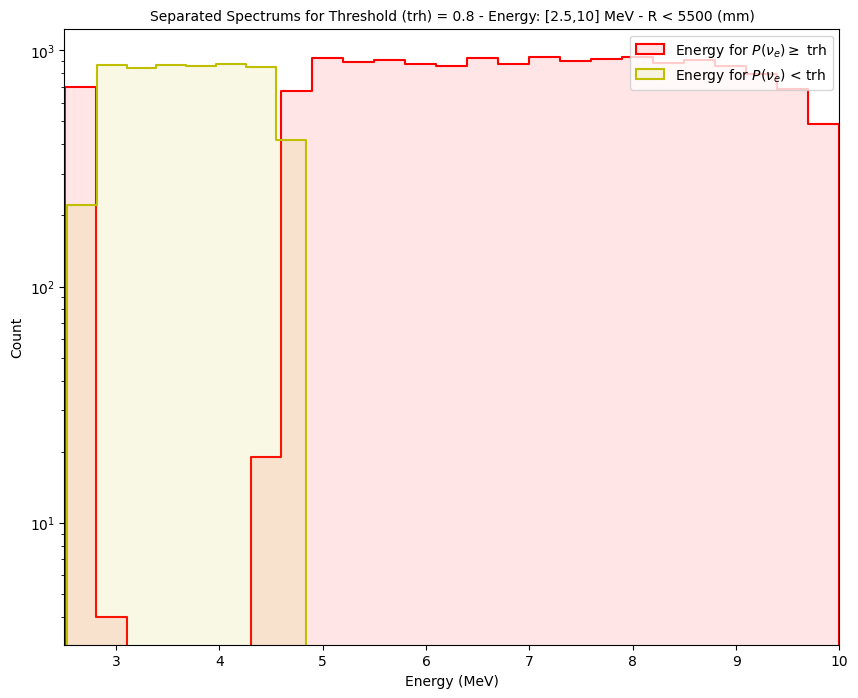

In [93]:
binwidth_en = 0.3
alpha_en_in = 0.1
alpha_en_out = 0.1
linewidth_en = 1.5

plt.figure(figsize =(10, 8))

#sn.histplot(tl_energy_in_spectrum, binwidth = binwidth_en, color = 'b', label = 'Energy for $P(Tl) \geq$ trh', 
#            alpha = alpha_en_in, linewidth = linewidth_en, element = 'step', kde = False)
#sn.histplot(tl_energy_out_spectrum, binwidth = binwidth_en, color = 'g', label = 'Energy for $P(Tl)$ < trh', 
#            alpha = alpha_en_out, linewidth = linewidth_en, element = 'step', kde = False)
sn.histplot(nu_energy_in_spectrum, binwidth = binwidth_en, color = 'r', label = 'Energy for $P(ν_e) \geq$ trh', 
            alpha = alpha_en_in, linewidth = linewidth_en, element = 'step', kde = False)
sn.histplot(nu_energy_out_spectrum, binwidth = binwidth_en, color = 'y', label = 'Energy for $P(ν_e)$ < trh', 
            alpha = alpha_en_out, linewidth = linewidth_en, element = 'step', kde = False)

#sn.histplot(energy_sig, bins = 20, color = 'r', label = 'All Solar $ν_e$ Spectrum', alpha = 0, linewidth = linewidth_en, element = 'step', kde = False)
plt.xlabel('Energy (MeV)')
plt.legend(loc = 'best')
plt.title('Separated Spectrums for Threshold (trh) = ' + str(threshold_p) + ' - Energy: [2.5,10] MeV - R < 5500 (mm)', fontsize = 10)
plt.yscale('log')
plt.xlim(2.5,10)
#plt.savefig('figs/First Model/10x10/effic_in_energy_pred_th.png', format = 'png', bbox_inches = 'tight')

### 3.4.6 - Efficience curve of predictions

Representar curva de eficiencia de las prediciones del modelo (sig=X_pred[:0], bkg=X_pred[:1]) en función de la energia y el radio del evento

In [94]:
#Efficiencia = Prob. de estar correcta la prediccion
X_sig_eff = X_sig_pred[:,0]
X_bkg_eff = X_bkg_pred[:,1]

x = np.concatenate((energy_sig_rc, energy_bkg_rc))
y = np.concatenate((radi_sig_rc, radi_bkg_rc))
z = np.concatenate((X_sig_eff, X_bkg_eff))

(2.5, 10.0)

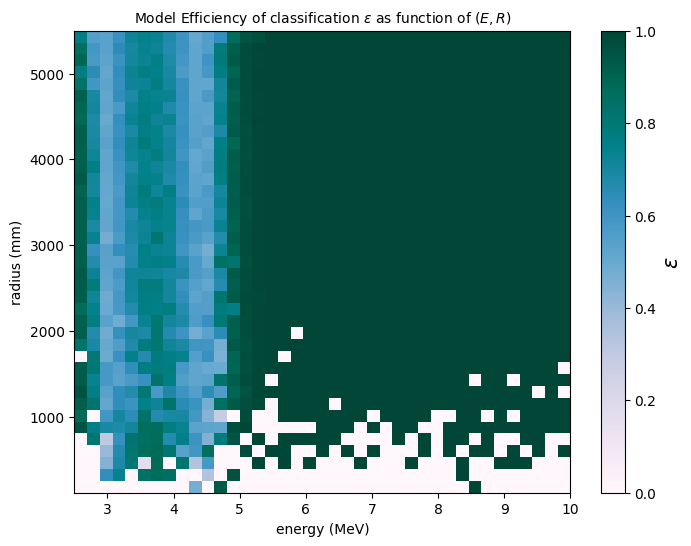

In [95]:
bins = 40

# Definir los límites y número de bins
x_edges = np.linspace(x.min(), x.max(), bins)
y_edges = np.linspace(y.min(), y.max(), bins)

# Inicializar una matriz para almacenar los valores de z
hist = np.zeros((len(x_edges)-1, len(y_edges)-1))

# Calcular los valores de z en cada bin
for i in range(len(x_edges)-1):
    for j in range(len(y_edges)-1):
        mask = (x >= x_edges[i]) & (x < x_edges[i+1]) & (y >= y_edges[j]) & (y < y_edges[j+1])
        if np.sum(mask) > 0:
            hist[i, j] = np.mean(z[mask])  # Otras estadísticas podrían ser np.sum, np.median, etc.

# Crear el plot
fig, ax = plt.subplots(figsize=(8,6))
c = ax.pcolormesh(x_edges, y_edges, hist.T, shading='auto', cmap = cm.PuBuGn)
cbar = fig.colorbar(c, ax=ax)

# Agregar un título a la barra de color
cbar.set_label('$ε$', fontsize = 15)

ax.set_xlabel('energy (MeV)')
ax.set_ylabel('radius (mm)')
ax.set_title('Model Efficiency of classification $ε$ as function of $(E,R)$', fontsize = 10)
plt.xlim(2.5,10)
#plt.ylim(0,5500)
#plt.savefig('figs/First Model/10x10/Eff_of_clasification(E,R).png', format = 'png', bbox_inches = 'tight')